In [1]:
import sys
import os
sys.path.append('D:\\SynologyDrive\\Univ\\kenkyuu\\gtrap\\gtrap')
os.environ['CPLUS_INCLUDE_PATH']=r'D:\SynologyDrive\Univ\kenkyuu\gtrap\include'

In [2]:
import time
import matplotlib.pyplot as plt
import math
import numpy as np
import pycuda.autoinit
import pycuda.driver as cuda
import pycuda.compiler
from pycuda.compiler import SourceModule
import geebls
import gfilter
import getstat
import read_tesslc as tes
from astropy.io import fits

In [3]:
def filename(sector,tic):
    if sector<=13:
        filename='F'
    else:
        filename='G'
    filename=filename+':\\/QLP/YEAR'
    if sector<=13:
        filename=filename+'1'
    else:
        filename=filename+'2'
    filename=filename+'/s'+str(sector).zfill(4)+'/'
    filename=filename+str(tic//1000000000000).zfill(4)+'/'+str(tic//100000000%10000).zfill(4)+'/'+str(tic//10000%10000).zfill(4)+'/'+str(tic%10000).zfill(4)+'/'
    filename=filename+'hlsp_qlp_tess_ffi_s'+str(sector).zfill(4)+'-'+str(tic).zfill(16)+'_tess_v01_llc.fits'
    return filename  

In [31]:
start = time.time()
dirlist=[filename(1,231663901)]
print(dirlist)
lc,tu,n,ntrue,nq,inval, bjdoffset,t0arr, t, det, info=tes.load_tesslc(dirlist)
#lc=2.0-lc
elapsed_time = time.time() - start
print (("2 :{0}".format(elapsed_time)) + "[sec]")
print(n,ntrue,nq)

['F:\\/QLP/YEAR1/s0001/0000/0002/3166/3901/hlsp_qlp_tess_ffi_s0001-0000000231663901_tess_v01_llc.fits']
2 :0.08364152908325195[sec]
2000 [1281] 1


In [32]:
lc=lc[tu!=[inval]]
tu=tu[tu!=[inval]]
lc=lc[tu!=[0.]]
tu=tu[tu!=[0.]]
lc=lc.reshape([len(lc),1])
tu=tu.reshape([len(tu),1])
n=len(lc)
ntrue=np.array([n])

In [33]:
print(tu)

[[1326.3906]
 [1326.4115]
 [1326.4324]
 ...
 [1354.0568]
 [1354.0776]
 [1354.0984]]


In [43]:
print(lc,type(lc),type(lc[0]))

[[1.0016263 ]
 [0.9999763 ]
 [0.99917203]
 ...
 [1.0022397 ]
 [0.99910796]
 [0.997668  ]] <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [34]:
offset,imgout=np.mean(lc,axis=1),lc #???

In [35]:
qmi = 0.01
qma = 0.1
max_period=10.0
min_period=0.2 
fmin=(1./(float(max_period)))                                          
df = 0.00003                                                                 
nf =  int((1./min_period)/df)
nb = 1024
min_duration_hours = 0.05
max_duration_hours = 1.0
qmi = float(min_duration_hours)/24./max_period
qma = float(max_duration_hours)/24./min_period                                                 
nb = 1024
print("Pmin=",1/(fmin+nf*df),"[d] Pmax=",1/fmin,"[d]")
print(nf)

Pmin= 0.19607920031058948 [d] Pmax= 10.0 [d]
166666


In [36]:
    tu=np.array(tu,order="C").astype(np.float32)
    start = time.time()
    dev_offset = cuda.mem_alloc(offset.astype(np.float32).nbytes)
    cuda.memcpy_htod(dev_offset,offset.astype(np.float32))
    
    dev_imgout=cuda.mem_alloc(imgout.astype(np.float32).nbytes)
    cuda.memcpy_htod(dev_imgout,imgout.astype(np.float32))
    
    dev_ntrue = cuda.mem_alloc(ntrue.nbytes)
    cuda.memcpy_htod(dev_ntrue,ntrue)
    
    dev_tu = cuda.mem_alloc(tu.astype(np.float32).nbytes)
    cuda.memcpy_htod(dev_tu,tu.astype(np.float32))
    
    blsp=np.zeros(nf*nq).astype(np.float32)
    dev_blsp = cuda.mem_alloc(blsp.nbytes)
    
    phase1=np.zeros(nf*nq).astype(np.uint32)
    dev_phase1 = cuda.mem_alloc(phase1.nbytes) 
    phase2=np.zeros(nf*nq).astype(np.uint32)
    dev_phase2 = cuda.mem_alloc(phase2.nbytes)  
    source_module=geebls.gbls_module()
    nthread=512
    pkernel=source_module.get_function("geebls")
    
    ##compute kma,kmi,kkmi
    kma=int(qma*nb)+1
    kmi=int(qmi*nb)
    kkmi=int(n*qmi)
    sharedsize=int(4*(nb+kma)*2+4*nb)
    pkernel(dev_blsp,dev_phase1,dev_phase2,dev_imgout,dev_tu,dev_offset,dev_ntrue,\
            np.uint32(n),np.uint32(nf),np.uint32(nb),\
            np.uint32(kma),np.uint32(kmi),np.uint32(kkmi),\
            np.float32(fmin),np.float32(df),\
            block=(nthread,1,1), grid=(int(nf),int(nq)),shared=sharedsize)
    #cuda.memcpy_dtoh(blsp,dev_blsp)
    #print(blsp)

    elapsed_time = time.time() - start
    print (("gbls :{0}".format(elapsed_time)) + "[sec] for # of batch="+str(nq))

gbls :1.5235557556152344[sec] for # of batch=1


In [37]:
Pest,sde,phasebest1,phasebest2=getstat.get_blsstat(dev_blsp,dev_phase1,dev_phase2,nf,nq,df,fmin)

In [38]:
print(Pest)
print(sde)
print(phasebest1/nb)
print(nb)
pphase1=Pest*phasebest1/nb
pphase2=Pest*phasebest2/nb
print(pphase1)
print(pphase2)
print((pphase2-pphase1)*24)

[1.43034915]
[9.82068735]
[0.73046875]
1024
[1.04482535]
[1.10349202]
[1.40799994]


In [39]:
#load BLS spectra on device
#cuda.memcpy_dtoh(blsp,dev_blsp)
#print(blsp)

In [40]:
dev_offset.free()
dev_imgout.free()
dev_ntrue.free()
dev_tu.free()
dev_blsp.free()
dev_phase1.free()
dev_phase2.free()

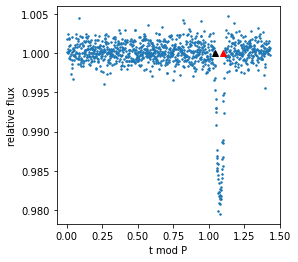

In [41]:
    #plot
    fig = plt.figure(figsize=(4,4))
    for j in range(0,np.min([nq,5])):
        ax=fig.add_subplot(np.min([nq,5]),1,j+1)
        ax.plot(np.mod(tu[:,j],Pest[j]), imgout[:,j],".",markersize=3)
        ax.plot([pphase1[j]],1,"^",color="black")
        ax.plot([pphase2[j]],1,"^",color="red")
        #plt.xlim(pphase1[j]-3,pphase2[j]+4)
        #plt.ylim(-0.005,0.003)
        #plt.text(pphase1[j]-2,0.002,dirlist[j].replace("/sharksuck/kic/data/",""))
        #plt.text(pphase1[j]-2,0.0025," P="+str(round(Pest[j],1))+"d"+" SDE="+str(round(sde[j],1)))
    plt.xlabel("t mod P")
    plt.ylabel("relative flux")
    plt.show()